In [1]:
using IonSim
using QuantumOptics
using QuantumOptics: timeevolution, stochastic
import DifferentialEquations
import PyPlot
const plt = PyPlot
using Distributions
using Expectations

In [2]:
# set some plot configs
plt.matplotlib.rc("xtick", top=false)
plt.matplotlib.rc("ytick", right=false, left=false)
plt.matplotlib.rc("axes", labelsize=16, titlesize=16, grid=true)
plt.matplotlib.rc("axes", linewidth=2)
plt.matplotlib.rc("grid", alpha=0.25, linestyle="--")
plt.matplotlib.rc("font", family="Palatino", weight="medium")
plt.matplotlib.rc("figure", figsize=(8,4))
plt.matplotlib.rc("xtick.major", width=2)
plt.matplotlib.rc("ytick.major", width=2)

In [45]:
C = Ca40(["S-1/2", "D-1/2"])
L = Laser()
νa = 1.0e6  # axial trap frequency
νr = 3.0e6    # radial trap frequency
chain = LinearChain(ions=[C], com_frequencies=(x=νr,y=νr,z=νa), vibrational_modes=(x=[], y=[], z=[1]))
T = Trap(configuration=chain, B=4e-4, Bhat=ẑ, δB=0, lasers=[L]);
L.k = (x̂ + ẑ)/√2 
L.ϵ = (x̂ - ẑ)/√2;
mode = T.configuration.vibrational_modes.z[1]

┌ Warning: !(ϵ ⟂ k)
└ @ IonSim C:\Users\suman\.julia\packages\IonSim\5Hvou\src\lasers.jl:84


VibrationalMode(ν=1.0e6, axis=ẑ, N=10)

In [46]:
get_η(mode, L, C)

0.06852224350584407

In [47]:
1/2e-6

500000.0

# RAP on RSB transition

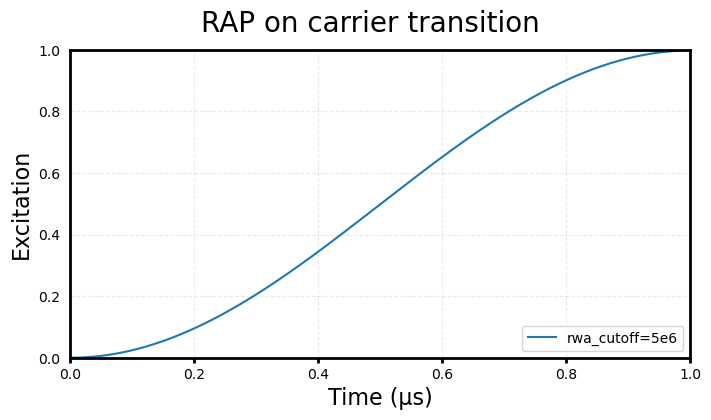

  0.002989 seconds (44.66 k allocations: 2.455 MiB)
0.9979183473928832

PyObject <matplotlib.legend.Legend object at 0x00000001068C6820>

In [149]:
T.B = 4e-4
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))
E = Efield_from_pi_time(1e-6, T, 1, 1, ("S-1/2", "D-1/2")) # t_pi = 1e-6 implies Rabi freq 2π X 500 kHz

# E = Efield_from_rabi_frequency(166e3, T, 1, 1, ("S-1/2", "D-1/2"))
mode.N = 30

n̄ = 0
ψi = C["S-1/2"] ⊗ mode[n̄]
ψi_ion = dm(C["S-1/2"])
ψi_mode = thermalstate(mode, n̄)
# ψi = ψi_ion ⊗ ψi_mode

Tp = 1 # the length of time of the frequency chirp in μs

#We’ll linearly sweep through the laser’s frequency from -100 kHz to +100 kHz detuned from the carrier transition in a time Tp
δν = 300e3 #frequency chirp length 200 kHz

# Δϕ is equal to half the detuning range we will chirp the laser over multiplied by the timescale (1e-6)
Δϕ = 2π * (δν/2) * 1e-6

# Set the frequency chirp
#L.ϕ = t -> (-Δϕ + (2Δϕ / Tp) * t) * t;

L.ϕ = 0

# amplitude Rabi_freq
function Ω(t)
    if t < Tp
        return 1*E*sin(π*t/Tp) #E*sin(π*t/Tp) #exp(-(t-Tp/2)^2/6000) ; sin(π * t / Tp)^2
    else
        return 0
    end
end
L.E = E;
L.Δ  = Δf #- mode.ν 


tspan = 0:0.001:Tp
h = hamiltonian(T, rwa_cutoff=5e6)
@time tout, ψt = timeevolution.schroedinger_dynamic(tspan, ψi, h, displacement="analytic")

ψo = ψt[end]  
p = expect(ionprojector(T, "D-1/2"), ψo)
print(abs(p))

ex1 = expect(ionprojector(T, "D-1/2"), ψt)

plt.plot(tout, ex1, label="rwa_cutoff=5e6")

#plt.plot(tout, @.(L.E(tout) / (0.2*E)), linestyle="--", label="scaled amplitude profile")

plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");
plt.suptitle("RAP on carrier transition", fontsize = 20)
plt.legend(loc="lower right", fontsize = 10)

In [10]:
# detuning_range = 2π*1e-6 .* collect(1e3:2e4:2e6)
# pops = Vector{Float64}(undef, 0)
# for Δϕ in detuning_range
#     L.ϕ = t -> (-Δϕ/2 + (Δϕ / Tp) * t) * t
#     h = hamiltonian(T)
#     _, sol = timeevolution.schroedinger_dynamic(tspan, C["S-1/2"] ⊗ mode[0], h)
#     push!(pops, real(expect(ionprojector(T, "D-1/2"), sol)[end]))
# end
# plt.plot(@.(detuning_range * 1e3), pops, lw=3, color="C1")
# plt.xlim(-10, detuning_range[end] * 1e3)
# plt.ylim(0, 1.01)
# plt.ylabel("Final Excited State\nPopulation")
# plt.xlabel("detuning range (kHz)");

### Amplitude and frequency profile

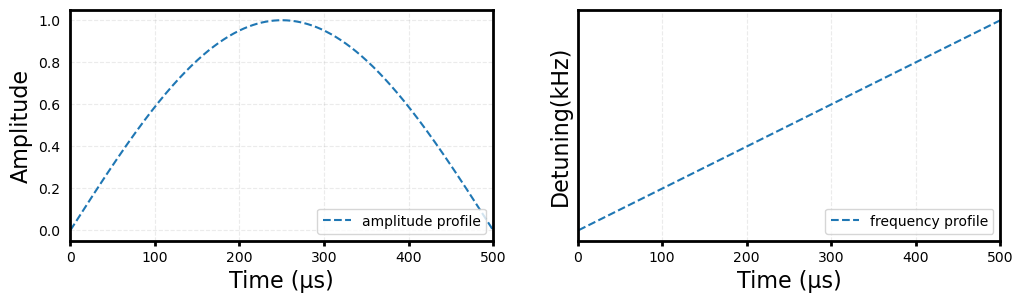

PyObject <matplotlib.legend.Legend object at 0x0000000062914580>

In [38]:
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(tout, @.(L.E(tout) / (2*E)), linestyle="--", label="amplitude profile")
plt.xlim([tout[1], tout[end]])
#plt.ylim(0, 1)
plt.ylabel("Amplitude")
plt.xlabel("Time (μs)");
plt.legend(loc="lower right", fontsize = 10)

plt.subplot(122)
plt.plot(tout, @.(L.ϕ(tout) / (2Δϕ * tout)), linestyle="--", label="frequency profile")
plt.xlim([tout[1], tout[end]])
#plt.ylim(0, 1)
plt.ylabel("Detuning(kHz)")
plt.xlabel("Time (μs)");
plt.yticks([])
plt.legend(loc="lower right", fontsize = 10)

In [39]:
p = expect(ionprojector(T, "D-1/2"), ψt[end])
p = real(p)
if p > 1
    p = 1
elseif p < 0
    p = 0
end
B = Bernoulli(p)
rand(B)

false

## scaling with fock states |n>; sequence rsb RAP pulse followed by carrier pi pulse

In [34]:
mode.N = 30
n̄ = 1
n = one(C) ⊗ IonSim.number(mode)

# ψi_ion = dm(C["S-1/2"])
# ψi_mode = thermalstate(mode, n̄)
# ψi = ψi_ion ⊗ ψi_mode

T.B = 4e-4
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))
E = Efield_from_pi_time(3e-6, T, 1, 1, ("S-1/2", "D-1/2"))

δν = 200e3 
Tp = 500 #μs
Δϕ = 2π * (δν/2) * 1e-6

# amplitude Rabi_freq
function Ω(t)
    if t < Tp
        return 2*E*sin(π*t/Tp) 
    else
        return 0
    end
end

number_of_repetitions = 100
phonon_number_measurement = 0
theoretical_nbar = 0

j = []
r = []

for k in 1:number_of_repetitions
    ψi = dm(C["S-1/2"]) ⊗ thermalstate(mode, n̄)
#     ψi = C["S-1/2"] ⊗ mode[n̄]
    theoretical_nbar = real(expect(n, ψi))
    i = 0
    while true
        # # simulation with RAP pulse on rsb transition

        L.ϕ = t -> (-Δϕ + (2Δϕ / Tp) * t) * t;
        L.E = Ω;
        L.Δ  = Δf - mode.ν 


        tspan = 0:1:Tp 
        h = hamiltonian(T, rwa_cutoff=5e6)
        tout, ψt = timeevolution.schroedinger_dynamic(tspan, ψi, h, displacement="analytic")

        ψo = ψt[end]

        p = expect(ionprojector(T, "D-1/2"), ψo)
        p = real(p)
        if p > 1
            p = 1
        elseif p < 0
            p = 0
        end
        B = Bernoulli(p)
        b = rand(B, 1)[1]
        if !b
            break
        else
        # simulation with pi pulse on carrier
            L.Δ = Δf
            E = Efield_from_pi_time(3e-6, T, 1, 1, ("S-1/2", "D-1/2"))
            L.E = E
            L.ϕ = 0

            tpi = 3 # length of pi pulse


            tlist = 0:tpi/300:tpi
            h = hamiltonian(T, rwa_cutoff=5e6)
            tout, ψt = timeevolution.schroedinger_dynamic(tlist, ψo, h, displacement="analytic")

            ψi = ψt[end]
            q = expect(ionprojector(T, "S-1/2"), ψi)
            push!(j, i)
            push!(r, q)
            i += 1
        end
    end
    phonon_number_measurement += i
    println(phonon_number_measurement)
end

average_phonon_number_measurement = phonon_number_measurement / number_of_repetitions
error = abs(theoretical_nbar - average_phonon_number_measurement) / theoretical_nbar;
println("average: ", average_phonon_number_measurement);
println("theoretical_nbar: ", theoretical_nbar);
println("error: ", error);

3
7
9
10
14
19
21
25
27
36
37
40
42
45
49
53
54
60
60
60
62
70
73
79
85
87
89
91
96
98
105
105
107
111
116
125
130
136
141
149
152
152
153
158
161
166
172
172
175
176
178
179
181
181
183
185
192
197
199
204
206
212
216
224
225
225
232
235
236
237
239
240
240
244
249
254
259
262
266
269
275
280
282
285
289
295
298
302
305
308
311
314
315
319
320
324
325
329
330
334
average: 3.34
theoretical_nbar: 9.601966560435988
error: 0.6521545894814756


## both rsb and carrier are with RAP pulse

In [37]:
mode.N = 30
n̄ = 0
n = one(C) ⊗ IonSim.number(mode)

T.B = 4e-4
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))
E = Efield_from_pi_time(1e-6, T, 1, 1, ("S-1/2", "D-1/2"))

δν = 300e3 
Tp = 300 #μs
Δϕ = 2π * (δν/2) * 1e-6

# amplitude Rabi_freq
function Ω(t)
    if t < Tp
        return 2*E*sin(π*t/Tp) 
    else
        return 0
    end
end

number_of_repetitions = 100
phonon_number_measurement = 0
theoretical_nbar = 0

j = []
r = []

for k in 1:number_of_repetitions
#     ψi = dm(C["S-1/2"]) ⊗ thermalstate(mode, n̄)
    ψi = C["S-1/2"] ⊗ mode[n̄]
    theoretical_nbar = real(expect(n, ψi))
    i = 0
    while true
        # # simulation with RAP pulse on rsb transition

        L.ϕ = t -> (-Δϕ + (2Δϕ / Tp) * t) * t;
        L.E = Ω;
        L.Δ  = Δf - mode.ν 


        tspan = 0:1:Tp 
        h = hamiltonian(T, rwa_cutoff=5e6)
        tout, ψt = timeevolution.schroedinger_dynamic(tspan, ψi, h, displacement="analytic")

        ψo = ψt[end]

        p = expect(ionprojector(T, "D-1/2"), ψo)
        p = real(p)
        if p > 1
            p = 1
        elseif p < 0
            p = 0
        end
        B = Bernoulli(p)
        b = rand(B, 1)[1]
        if !b
            break
        else
        # simulation with pi pulse on carrier
            
#             E = Efield_from_pi_time(3e-6, T, 1, 1, ("S-1/2", "D-1/2"))
            tpi = 3 # length of pi pulse
            function Ω1(t)
                if t < tpi
                    return 2*E*sin(π*t/tpi) 
                else
                    return 0
                end
            end
            L.ϕ = t -> (-Δϕ + (2Δϕ / tpi) * t) * t;
            L.E = Ω1;
            L.Δ  = Δf 

            tlist = 0:tpi/300:tpi
            h = hamiltonian(T, rwa_cutoff=5e6)
            tout, ψt = timeevolution.schroedinger_dynamic(tlist, ψo, h, displacement="analytic")

            ψi = ψt[end]
            q = expect(ionprojector(T, "S-1/2"), ψi)
            push!(j, i)
            push!(r, q)
            i += 1
        end
    end
    phonon_number_measurement += i
    println(phonon_number_measurement)
end

average_phonon_number_measurement = phonon_number_measurement / number_of_repetitions
error = abs(theoretical_nbar - average_phonon_number_measurement) / theoretical_nbar;
println("average: ", average_phonon_number_measurement);
println("theoretical_nbar: ", theoretical_nbar);
println("error: ", error);

1
1
2
2
3
3
3
3
4
4
4
5
7
7
8
10
10
11
11
11
11
11
12
12
12
13
13
13
14
14
15
16
17
18
18
18
18
18
18
18
19
19
19
19
19
19
19
20
21
21
21
22
22
22
22
23
24
24
25
25
26
27
27
27
27
28
28
28
28
28
28
28
28
29
29
29
30
30
30
31
32
32
32
32
32
32
32
32
33
33
34
34
34
34
35
35
36
36
37
39
average: 0.39
theoretical_nbar: 0.4999999999999998
error: 0.21999999999999964


In [41]:
println(r)
println(j)

Any[0.9976581834004813 + 0.0im, 0.9970019941143266 + 0.0im, 0.9967557137083312 + 0.0im, 0.9963631408403297 + 0.0im, 0.9953589619820189 + 0.0im]
Any[0, 1, 2, 3, 4]


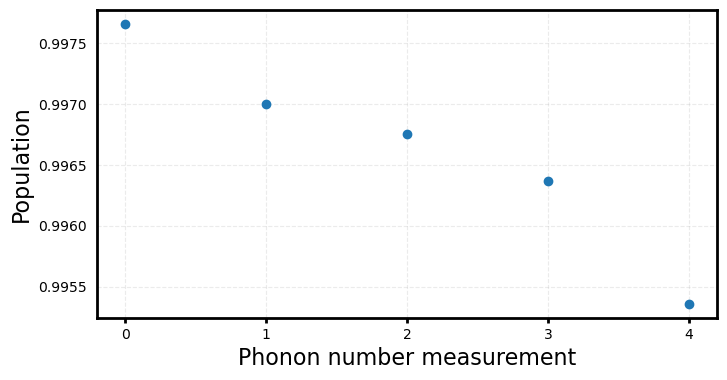

In [42]:
plt.plot(j,r, "o")

# num_bins = 10
# n, bins, patches  = plt.hist(j, num_bins)
# plt.show()
plt.ylabel("Population")
plt.xlabel("Phonon number measurement");
#plt.ylim(0,1.5)
plt.xticks([0,1,2,3,4]);

In [227]:
mode.N = 50

n̄ = 0.2
n = one(C) ⊗ IonSim.number(mode)
ψi = dm(C["S-1/2"]) ⊗ thermalstate(mode, n̄)
#ψi = C["S-1/2"] ⊗ mode[n̄]
theoretical_nbar = real(expect(n, ψi))
print(theoretical_nbar)

0.20000000000000004